In [ ]:
!pip install pgmpy

In [22]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import TreeSearch, MaximumLikelihoodEstimator
from pgmpy.estimators import BayesianEstimator

In [6]:
import pickle
import networkx as nx
import matplotlib.pyplot as plt

In [7]:
# Загружаем датасет
adult_data = pd.read_csv('adult.csv')

# Подготавливаем данные
label_encoder = LabelEncoder()
for column in adult_data.columns:
    if adult_data[column].dtype == type(object):
        adult_data[column] = label_encoder.fit_transform(adult_data[column])
        
# Разбиваем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(adult_data.drop('income', axis=1),
                                                    adult_data['income'], test_size=0.3, random_state=42)

# Определяем порядок переменных на основе корреляций
corr_matrix = adult_data.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
pairs = upper.stack().sort_values(ascending=False)
variable_order = [pairs.index[i][0] for i in range(len(pairs))]

In [ ]:
# Определяем родительские переменные
parent_variables = {}
for variable in variable_order:
    possible_parents = list(variable_order[:variable_order.index(variable)])
    if not possible_parents:
        parent_variables[variable] = None
    else:
        mutual_info = []
        for parent in possible_parents:
            mi = mutual_info_classif(X_train[[parent]], X_train[variable], random_state=42)[0]
            mutual_info.append(mi)
        parent_variables[variable] = possible_parents[np.argmax(mutual_info)]
        


In [ ]:
# Строим TAN модель
tan_edges = []
for variable, parent in parent_variables.items():
    if parent is not None:
        tan_edges.append((parent, variable))

In [ ]:
tan_edges.append(('relationship', 'income'))
tan_edges.append(('education', 'income'))
tan_edges.append(('age', 'income'))
tan_edges.append(('marital-status', 'income'))
tan_edges.append(('workclass', 'income'))
tan_edges.append(('race', 'income'))
tan_edges.append(('gender', 'income'))
tan_edges.append(('occupation', 'income'))
tan_edges.append(('fnlwgt', 'income'))
tan_edges.append(('native-country', 'income'))
tan_edges.append(('hours-per-week', 'income'))
tan_edges.append(('capital-gain', 'income'))
tan_edges.append(('capital-loss', 'income'))
tan_edges.append(('educational-num', 'income'))

In [ ]:
tan_model = BayesianNetwork(tan_edges)

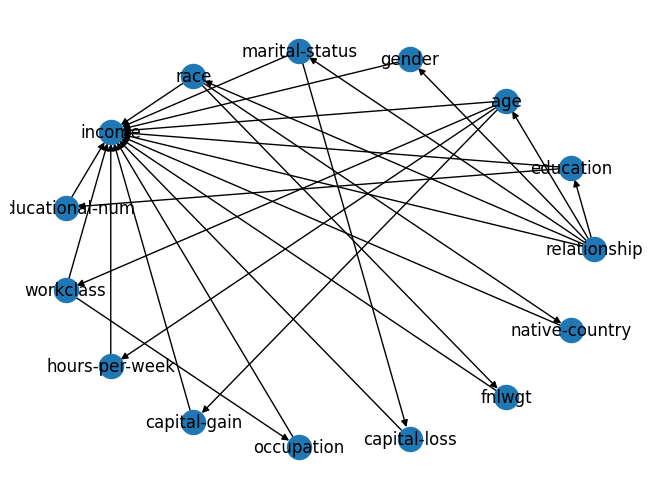

In [18]:
pos = nx.circular_layout(tan_model)
nx.draw(tan_model, pos, with_labels=True)
plt.show()

In [ ]:
# сохраняем модель в файл
with open('tan_model.pkl', 'wb') as f:
    pickle.dump(tan_model, f)

In [9]:
# загружаем модель
with open('tan_model.pkl', 'rb') as f:
    tan_model = pickle.load(f)

In [25]:
b_est = BayesianEstimator(tan_model, adult_data)

In [ ]:
print('\nВывод условных вероятностей BayesianEstimator')
for i in adult_data:
    print(b_est.estimate_cpd(i))

In [23]:
# переводим модель в объект BayesianModel
bayesian_model = BayesianNetwork(tan_model.edges)

# создаем таблицы CPD для каждого узла
for node in bayesian_model.nodes:
    cpd = MaximumLikelihoodEstimator(bayesian_model, adult_data).estimate_cpd(node)
    bayesian_model.add_cpds(cpd)

ValueError: ignored

In [20]:
tan_model.fit(adult_data, estimator=MaximumLikelihoodEstimator)

ValueError: ignored